- Created 0984310-F_1.csv
- Created 0043121-X_2.csv
- Created 0984311-F_3.csv
- Created 0970100-F_4.csv
- Created 0128800-F_5.csv
- Created 0460542-F_6.csv
- Created 0058991-A_7.csv
- Created 0058990-A_8.csv
- Created 0972100-F_9.csv
- Created 0971810-F_10.csv

In [1]:
# EDA Libraries:

import pandas as pd
import numpy as np

import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
from pathlib import Path  
import random

# Scikit-Learn models:

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# LSTM:

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import LSTM


# ARIMA Model:

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse


import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# df = pd.read_excel("data/WFF Shipping Data.xlsx")

In [2]:
def load_data(file_name):
#     return pd.read_csv(file_name)
    return pd.read_excel(file_name)


sales_data = load_data("data/WFF Shipping Data.xlsx")
sales_data = sales_data[["Sku", "Created", "AdjustmentQty"]]
# sales_data = load_data("data/SKU/0984310-F_1.csv")
sales_data.columns = ['item', 'date', 'sales']
df_s = sales_data.copy()
df_s.sort_values(by='date', inplace=True)
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398485 entries, 12202 to 392183
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   item    398485 non-null  object
 1   date    398485 non-null  object
 2   sales   398485 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 12.2+ MB


In [3]:
df_s['sales'].describe()

count    398485.000000
mean          4.277002
std          14.252415
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1249.000000
Name: sales, dtype: float64

<Axes: >

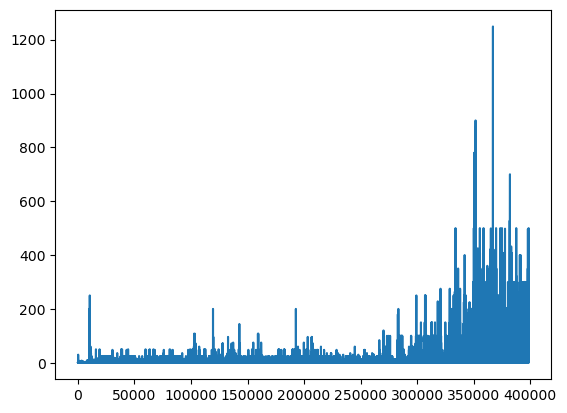

In [4]:
df_s['sales'].plot()

In [5]:
def monthlyORyears_sales(data,time=['monthly','years']):
    data = data.copy()
    if time == "monthly":
        # Drop the day indicator from the date column:
        data.date = data.date.apply(lambda x: str(x)[:-3])
    else:
        data.date = data.date.apply(lambda x: str(x)[:4])
        
   # Sum sales per month: 
    data = data.groupby('date')['sales'].sum().reset_index()
    data.date = pd.to_datetime(data.date)
        
    return data





m_df = monthlyORyears_sales(df_s,"monthly")
m_df.sort_values(by='date', inplace=True)
m_df.to_csv('data/SKU/monthly_data.csv')
# y_df = monthlyORyears_sales(df_s,"years")
# y_df

In [6]:
# def sales_time(data):
#     """Time interval of dataset:"""

#     data.date = pd.to_datetime(data.date)
#     n_of_days = data.date.max() - data.date.min()
#     n_of_years = int(n_of_days.days / 365)
    
#     print(f"Days: {n_of_days.days}\nYears: {n_of_years}\nMonth: {12 * n_of_years}")
    
# def sales_per_store(data):
#     sales_by_store = data.groupby('item')['sales'].sum().reset_index()
    
#     fig, ax = plt.subplots(figsize=(8,6))
#     sns.barplot(sales_by_store.store, sales_by_store.sales, color='darkred')
    
#     ax.set(xlabel = "Store Id", ylabel = "Sum of Sales", title = "Total Sales Per Store")
    
#     return sales_by_store

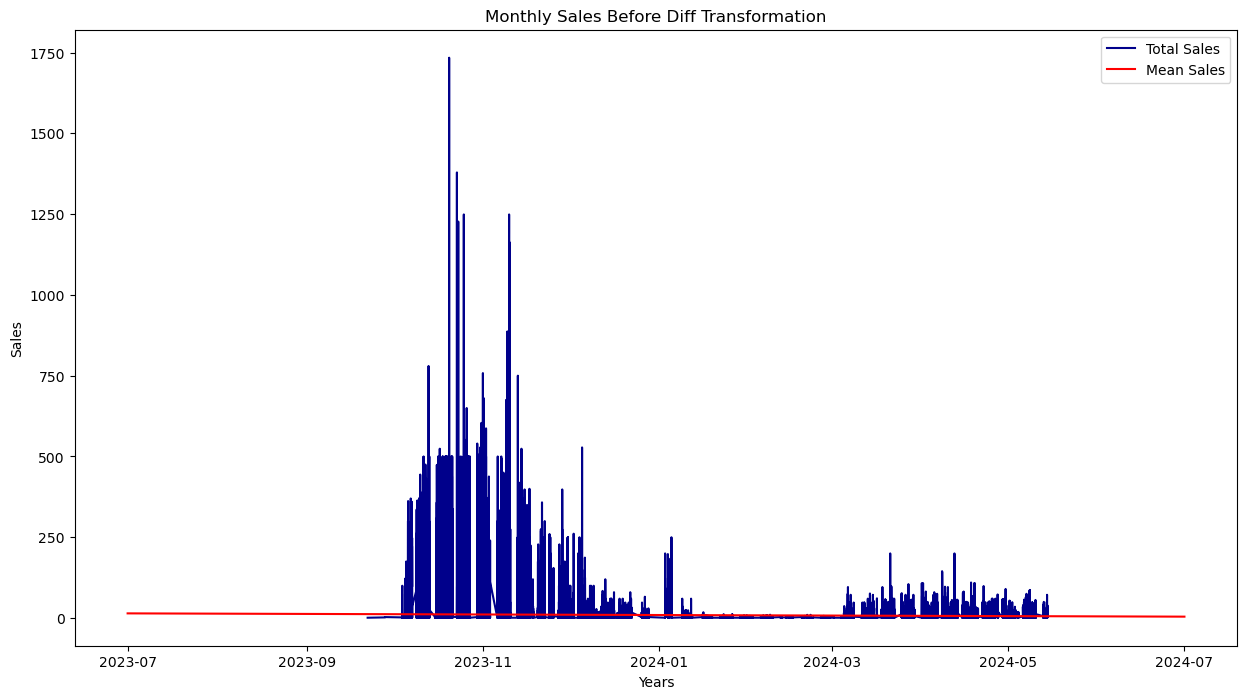

In [7]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.lineplot(x=x_col, y=y_col, data=data, ax=ax, color='darkblue', label='Total Sales')
    
    s_mean = data.groupby(data[x_col].dt.year)[y_col].mean().reset_index()
    s_mean[x_col] = pd.to_datetime(s_mean[x_col], format='%Y')
    sns.lineplot(x=s_mean[x_col] + pd.DateOffset(months=6), y=y_col, data=s_mean, ax=ax, color='red', label='Mean Sales')
    
    ax.set(xlabel="Years",
           ylabel="Sales",
           title=title)
    plt.legend()
    plt.show()

# Example usage
time_plot(m_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation')

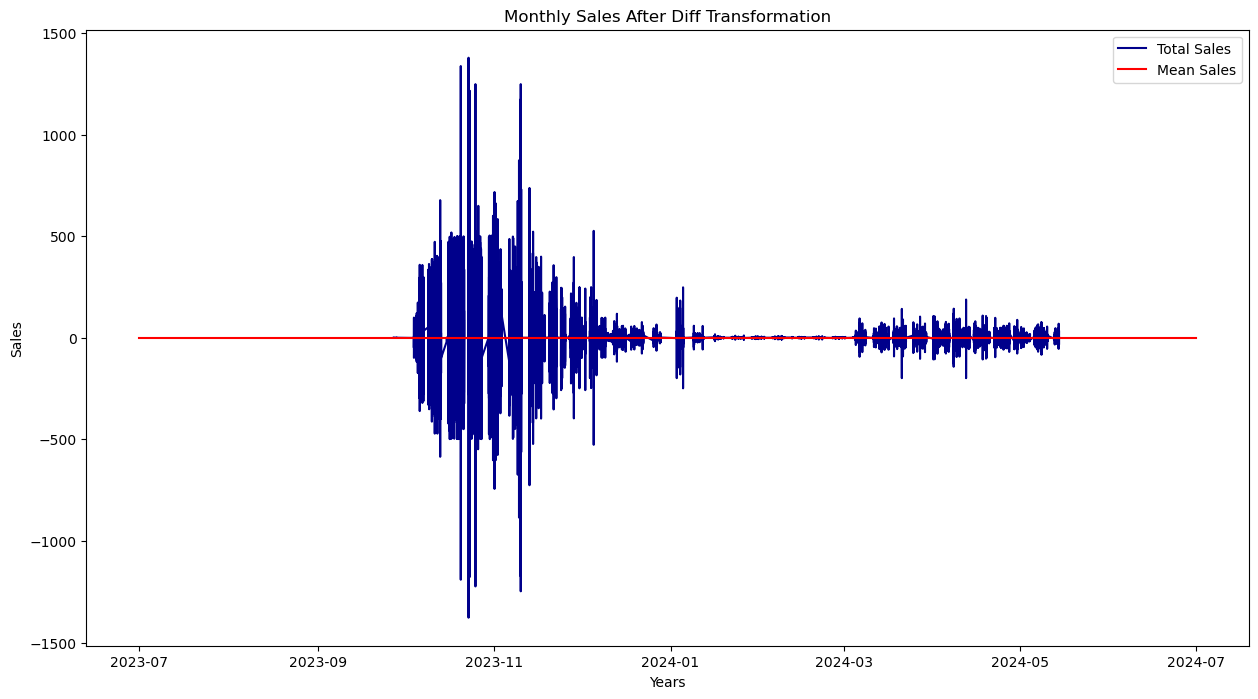

In [8]:
def get_diff(data):
    """Calculate the difference in sales month over month:"""
    
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('./stationary_df.csv')
    
    return data

stationary_df = get_diff(m_df)
stationary_df = stationary_df.sort_values(by='date')
time_plot(stationary_df, 'date', 'sales_diff', 
          'Monthly Sales After Diff Transformation')

## Preparing Dataset Modeling
### ARIMA

For our Arima model, we will need only a datetime index and the dependent variable (diff in sales) columns.

In [9]:
def build_arima_data(data):
    """Generates a csv-file with a datetime index and a dependent sales column for ARIMA modeling."""
    
    da_data = data.set_index('date').drop('sales', axis=1)
    da_data.dropna(axis=0)
    
    da_data.to_csv('data/SKU/arima_df.csv')
    
    return da_data


datatime_df = build_arima_data(stationary_df)
datatime_df = datatime_df.sort_index()


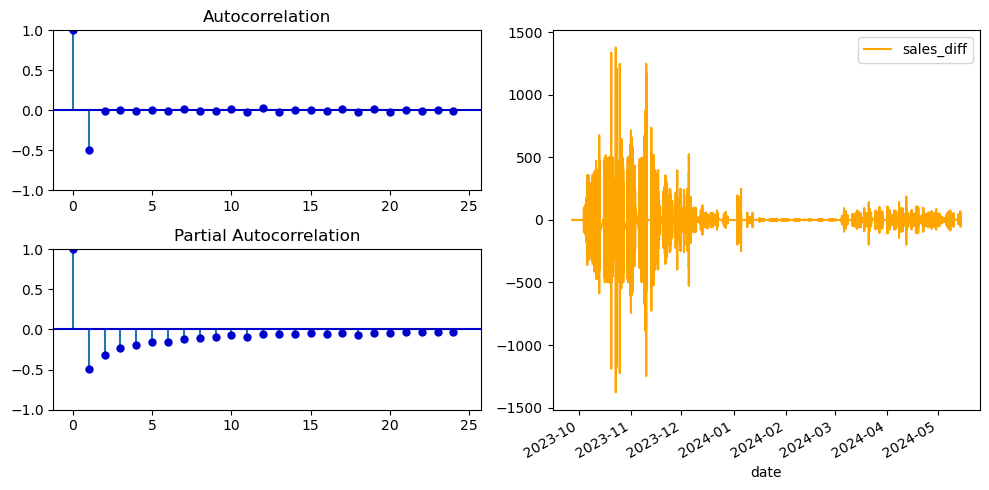

In [10]:
def plots_lag(data, lags=None):
    """Convert dataframe to datetime index"""
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    
    law  = plt.subplot(122)
    acf  = plt.subplot(221)
    pacf = plt.subplot(223)
    
    dt_data.plot(ax=law, figsize=(10, 5), color='orange')
    # Plot the autocorrelation function:
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    
    # Will also adjust spacing between subplots to minimize the overlaps:
    plt.tight_layout()

plots_lag(stationary_df, lags=24);

### Regressive Modeling

In [11]:
def built_supervised(data):
    supervised_df = data.copy()

    # Create column for each lag:
    for i in range(1, 13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)

    # Drop null values:
    supervised_df = supervised_df.dropna().reset_index(drop=True)

    supervised_df.to_csv('./model_df.csv', index=False)
    
    return supervised_df


model_df = built_supervised(stationary_df)
model_df 

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2023-10-04 01:33:12,1,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,1.0,0.0,1.0
1,2023-10-04 01:42:01,2,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,1.0,0.0
2,2023-10-04 01:45:41,1,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,1.0
3,2023-10-04 01:53:06,2,1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0
4,2023-10-04 01:53:39,2,0.0,1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183757,2024-05-14 12:59:31,3,-34.0,35.0,1.0,-15.0,14.0,1.0,0.0,-2.0,0.0,2.0,-2.0,-8.0,5.0
183758,2024-05-14 12:59:41,1,-2.0,-34.0,35.0,1.0,-15.0,14.0,1.0,0.0,-2.0,0.0,2.0,-2.0,-8.0
183759,2024-05-14 12:59:45,2,1.0,-2.0,-34.0,35.0,1.0,-15.0,14.0,1.0,0.0,-2.0,0.0,2.0,-2.0
183760,2024-05-14 12:59:50,1,-1.0,1.0,-2.0,-34.0,35.0,1.0,-15.0,14.0,1.0,0.0,-2.0,0.0,2.0


### Train-Test spllit

In [12]:
model_df

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2023-10-04 01:33:12,1,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,1.0,0.0,1.0
1,2023-10-04 01:42:01,2,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,1.0,0.0
2,2023-10-04 01:45:41,1,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,1.0
3,2023-10-04 01:53:06,2,1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0
4,2023-10-04 01:53:39,2,0.0,1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183757,2024-05-14 12:59:31,3,-34.0,35.0,1.0,-15.0,14.0,1.0,0.0,-2.0,0.0,2.0,-2.0,-8.0,5.0
183758,2024-05-14 12:59:41,1,-2.0,-34.0,35.0,1.0,-15.0,14.0,1.0,0.0,-2.0,0.0,2.0,-2.0,-8.0
183759,2024-05-14 12:59:45,2,1.0,-2.0,-34.0,35.0,1.0,-15.0,14.0,1.0,0.0,-2.0,0.0,2.0,-2.0
183760,2024-05-14 12:59:50,1,-1.0,1.0,-2.0,-34.0,35.0,1.0,-15.0,14.0,1.0,0.0,-2.0,0.0,2.0


In [13]:
def train_test_split(data):
    data = data.drop(['sales','date'], axis=1)
    train , test = data[:-30000].values, data[-30000:].values
    
    return train, test

train, test = train_test_split(model_df)
print(f"Shape of  Train: {train.shape}\nShape of  Test: {test.shape}")

Shape of  Train: (153762, 13)
Shape of  Test: (30000, 13)


### Scale

In [14]:
def scale_data(train_set,test_set):
    """Scales data using MinMaxScaler and separates data into X_train, y_train,
    X_test, and y_test."""
    
    # Apply Min Max Scaler:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # Reshape training set:
    train_set = train_set.reshape(train_set.shape[0],
                                  train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # Reshape test set:
    test_set = test_set.reshape(test_set.shape[0], 
                                test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel() # returns the array, flattened!
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler


X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
print(f"Shape of X Train: {X_train.shape}\nShape of y Train: {y_train.shape}\nShape of X Test: {X_test.shape}\nShape of y Test: {y_test.shape}")

Shape of X Train: (153762, 12)
Shape of y Train: (153762,)
Shape of X Test: (30000, 12)
Shape of y Test: (30000,)


In [15]:
def re_scaling(y_pred, x_test, scaler_obj, lstm=False):
    """For visualizing and comparing results, undoes the scaling effect on predictions."""
   # y_pred: model predictions
   # x_test: features from the test set used for predictions
   # scaler_obj: the scaler objects used for min-max scaling
   # lstm: indicate if the model run is the lstm. If True, additional transformation occurs 
    
    # Reshape y_pred:
    y_pred = y_pred.reshape(y_pred.shape[0],
                            1,
                            1)

    if not lstm:
        x_test = x_test.reshape(x_test.shape[0],
                                1, 
                                x_test.shape[1])

    # Rebuild test set for inverse transform:
    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], 
                                             x_test[index]],
                                             axis=1) )

    # Reshape pred_test_set:
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0],
                                          pred_test_set.shape[2])

    # Inverse transform:
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted










def prediction_df(unscale_predictions, origin_df):
    result_list = []
    sales_dates = list(origin_df['date'][-30000:])  # Ensuring alignment with test data
    act_sales = list(origin_df['sales'][-30000:])  # Ensure sales correspond to the dates

    for index in range(len(unscale_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscale_predictions[index][0])
        result_dict['date'] = sales_dates[index]
        result_list.append(result_dict)
    
    df_result = pd.DataFrame(result_list)
    df_result = df_result.sort_values(by='date')
    origin_df = origin_df.sort_values(by='date')
    return df_result





model_scores = {}

def get_scores(unscale_df, origin_df, model_name):
    """Prints the root mean squared error, mean absolute error, and r2 scores
    for each model. Saves all results in a model_scores dictionary for
    comparison."""
    
    rmse = np.sqrt(mean_squared_error(origin_df.sales[-30000:], 
                                      unscale_df.pred_value[-30000:]))
    
    mae = mean_absolute_error(origin_df.sales[-30000:], 
                              unscale_df.pred_value[-30000:])
    
    r2 = r2_score(origin_df.sales[-30000:], 
                  unscale_df.pred_value[-30000:])
    
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")



def plot_results(results, origin_df, model_name):
    # results: a dataframe with unscaled predictions
    results = results.sort_values('date')
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Plot original sales data
    sns.lineplot(x='date', y='sales', data=origin_df, ax=ax, label='Original', color='blue')
    
    # Plot predicted sales data
    sns.lineplot(x='date', y='pred_value', data=results, ax=ax, label='Predicted', color='red')
    
    # Set plot labels and title
    ax.set(xlabel="Date",
           ylabel="Sales",
           title=f"{model_name} Sales Forecasting Prediction")
    
    # Add legend
    ax.legend(loc='best')
    
    # Save plot to file
    filepath = Path(f'./model_output/{model_name}_forecasting.svg')  
    filepath.parent.mkdir(parents=True, exist_ok=True) 
    plt.savefig(filepath)

    # Show plot
    plt.show()





def regressive_model(train_data, test_data, model, model_name):
    """Runs regressive models in SKlearn framework. First calls scale_data
    to split into X and y and scale the data. Then fits and predicts. Finally,
    predictions are unscaled, scores are printed, and results are plotted and
    saved."""
    
    # Split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data,
                                                                 test_data)

    # Run sklearn models:
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test) # y_pred=predictions

    # Undo scaling to compare predictions against original data:
    origin_df = m_df
    origin_df = origin_df.sort_values(by='date')
    unscaled = re_scaling(predictions, X_test, scaler_object) # unscaled_predictions
    unscaled_df = prediction_df(unscaled, origin_df)

    # Print scores and plot results:
    get_scores(unscaled_df, origin_df, model_name)
    plot_results(unscaled_df, origin_df, model_name)

RMSE: 8.83219300815677
MAE: 5.909566666666667
R2 Score: -1.6535210627220054


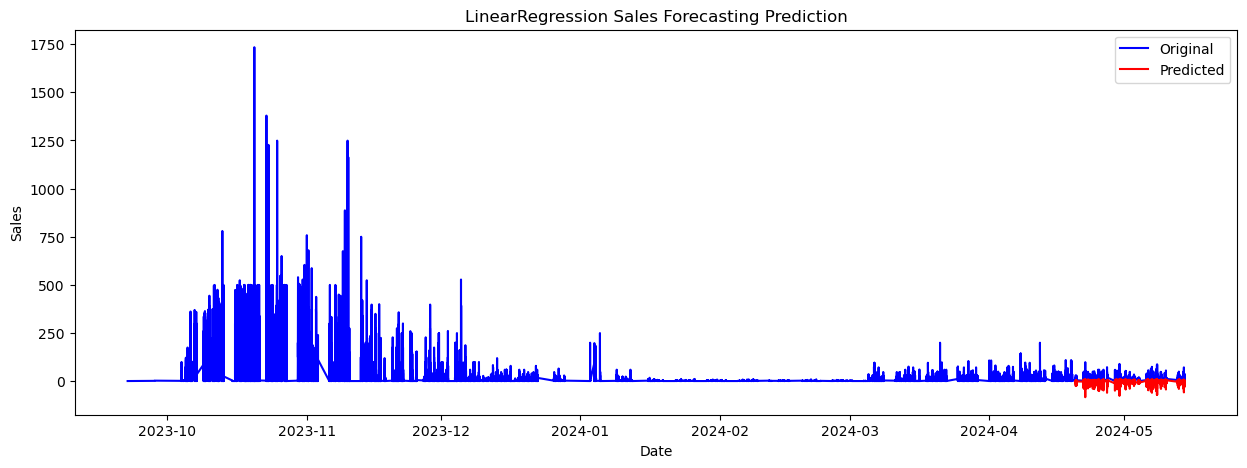

In [16]:
regressive_model(train, test, LinearRegression(), 'LinearRegression')

RMSE: 8.764855960025812
MAE: 5.5915
R2 Score: -1.61321416679958


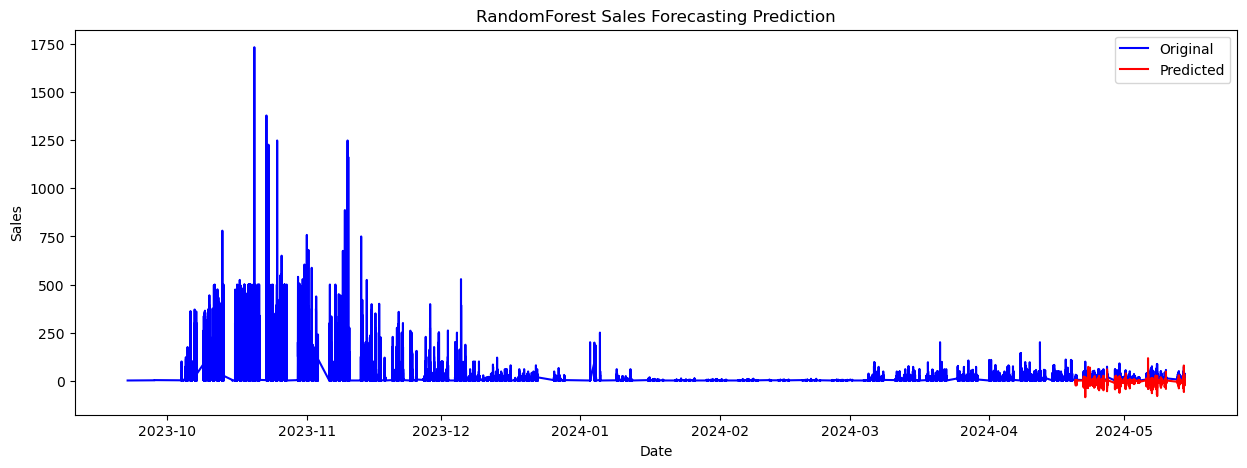

In [17]:
regressive_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

RMSE: 8.476679774534366
MAE: 5.6587
R2 Score: -1.444201415240986


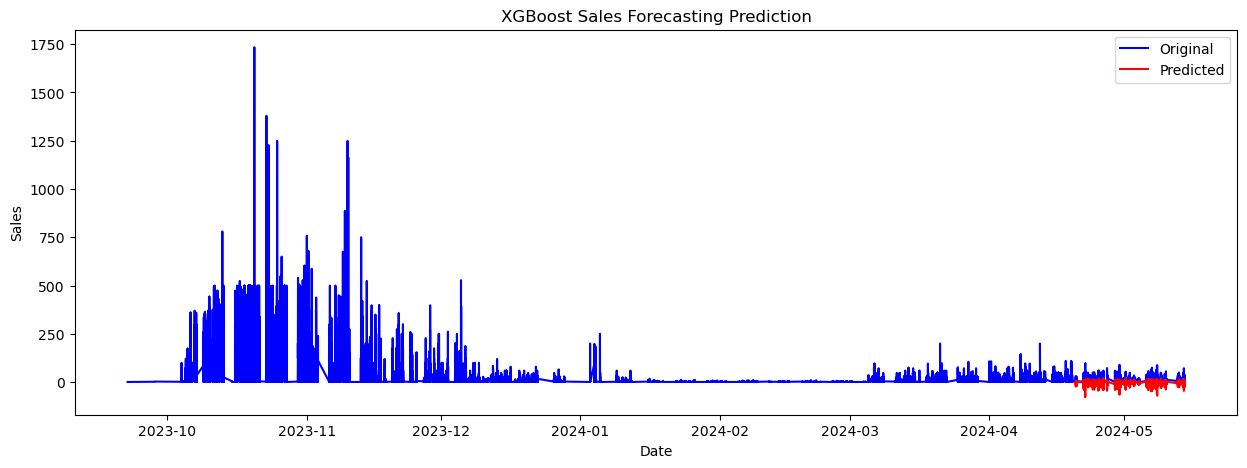

In [18]:
regressive_model(train, test, XGBRegressor(n_estimators=100,max_depth=3, 
                                           learning_rate=0.2,objective='reg:squarederror'), 'XGBoost')

## LSTM

In [19]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense

# def lstm_model(train_data, test_data):
#     """Runs a long-short-term-memory neural net with 2 dense layers. 
#     Generates predictions that are then unscaled. 
#     Scores are printed and the results are plotted and saved."""
    
#     # Split into X & y and scale data:
#     X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
#     # Reshape X_train and X_test to include one time step per sample:
#     X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
#     X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
#     # Build LSTM model:
#     model = Sequential()
#     # Correct use of batch_input_shape for stateful LSTM:
#     model.add(LSTM(4, batch_input_shape=(1, 1, X_train.shape[2]), stateful=True))
#     model.add(Dense(1))
#     model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    
#     # Fit the model with state reset after each epoch:
#     for i in range(50):  # Assuming 50 epochs
#         model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=1, shuffle=False)
#         model.reset_states()
    
#     # Make predictions:
#     predictions = model.predict(X_test, batch_size=1)
    
#     # Undo scaling to compare predictions against original data:
#     origin_df = m_df  # Make sure 'm_df' is defined as your original DataFrame with 'sales' and 'date'
#     unscaled = re_scaling(predictions, X_test, scaler_object, lstm=True)
#     unscaled_df = prediction_df(unscaled, origin_df)
    
#     # Evaluate model performance:
#     get_scores(unscaled_df, origin_df, 'LSTM')
    
#     # Plot and save the results:
#     plot_results(unscaled_df, origin_df, 'LSTM')

# # Assuming 'train' and 'test' are defined and properly formatted:
# lstm_model(train, test)
